# Face Mask Detection

## Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
import urllib
import matplotlib.pyplot as plt
import cv2                                 # opencv-python installed with 'pip'
import matplotlib.patches as patches
import tensorflow as tf                    # TensorFlow installed with 'pip'
import keras
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, load_model        # keras is only compatible with python 3.6 or lower
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import sklearn
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


# Loading Dataset

+ [Face Mask Detection Dataset (Kaggle)](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

In [147]:
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = notebook_dir[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
HC_DATA_DIR = os.path.join(DATA_DIR, 'haar_cascades')
KAGGLE_GIT_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images"

In [44]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'img_data/kaggle_testing.csv'))
train

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


## There are 6024 images

+ CAVEAT -- The images are hosted remotely. I just happen to know how many files there are :)

In [48]:
image_formats = ['jpg', 'jpeg', 'png']
# a = os.listdir(images_dir)
a = list(set(list(test['name']) + list(train['name'])))
a = [img for img in a if img.split(".")[-1] in image_formats]
b = os.listdir(annotations_dir)
a.sort()
b.sort()

Text(0.5, 1.0, 'Mask vs No Mask Distribution')

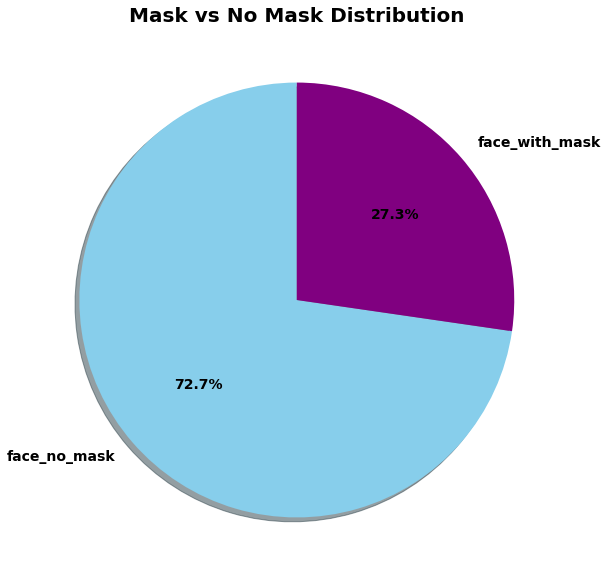

In [145]:
len(a)
labels = list(train['classname'].unique())
fig = plt.figure(figsize=(10,10))
plot = plt.pie(
    train.classname.value_counts(), 
    labels = labels, 
    autopct = '%1.1f%%',
    shadow = True, 
    startangle = 90,
    colors = ['skyblue', 'purple'],
    textprops = {'size': 14, 'weight': 'bold', 'color': 'black'}
)
plt.title("Mask vs No Mask Distribution", size=20, weight='bold')

In [146]:
train_images=a[1698:]
test_images=a[:1698]

Just to prove there's at least one image

In [56]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name', axis=0, inplace=True)

/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[[480, 144, 636, 350], [583, 82, 730, 266], [367, 50, 503, 220], [95, 158, 294, 376]]


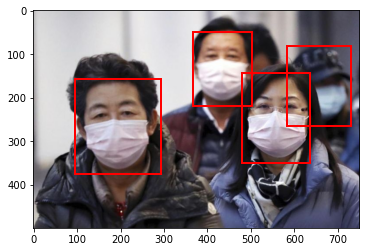

In [57]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

url = os.path.join(KAGGLE_GIT_DIR, "{}?raw=true".format(image))
resp = urllib.request.urlopen(url)
img = plt.imread(resp, format='jpg')
# image = np.asarray(bytearray(resp.read()), dtype="uint8")
# img = cv2.imdecode(image, cv2.IMREAD_ANYCOLOR)

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


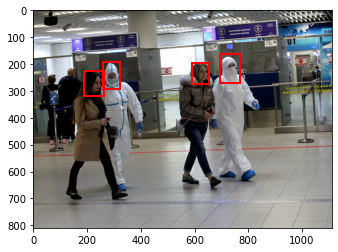

In [58]:
image=train_images[5]

# img=plt.imread(os.path.join(images_dir,image))
url = os.path.join(KAGGLE_GIT_DIR, "{}?raw=true".format(image))
resp = urllib.request.urlopen(url)
img = plt.imread(resp, format='jpg')
# image = np.asarray(bytearray(resp.read()), dtype="uint8")
# img = cv2.imdecode(image, cv2.IMREAD_ANYCOLOR)


fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle(
        (box[0],box[1]),box[2]-box[0],box[3]-box[1],
        linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


In [ ]:
fig = plt.figure(figsize=(18., 8))
plt.pie(train.classname.value_counts(), 
        labels = ['face_with_mask','face_no_mask'], 
        autopct = '%1.1f%%',
        shadow = True, startangle = 90)

# Creating/Preparing Training Data

+ NOTE: Since the images are not hosted locally, creating the training data takes a little extra time
  + Last time it ran, it took 55m 44s to get through this part
+ Essentially, there are three steps to this part:
  1. Read the image from the remote source, or grab the data from the imdata_dict if we've already read it
  2. Crop the image according to the bounding box coordinates provided in the train dataframe
  3. Add the cropped data and the classname (provided in train dataframe) to the data list

In [67]:
img_size=50
data=[]
path = images_dir
imdata_dict = {}

def create_data():
    for i in range(len(train)):
        arr=[]
        for j in train.iloc[i]:
               arr.append(j)
                
        if arr[0] in imdata_dict.keys():
            img_array = imdata_dict[arr[0]]
        else:
    #         img_array = cv2.imread(os.path.join(images_dir, arr[0]), cv2.IMREAD_GRAYSCALE)
            url = os.path.join(KAGGLE_GIT_DIR, "{}?raw=true".format(arr[0]))
            resp = urllib.request.urlopen(url)
            image = np.asarray(bytearray(resp.read()), dtype="uint8")
            img_array = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
            imdata_dict[arr[0]] = img_array
        
        crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
        new_img_array = cv2.resize(crop_image, (img_size, img_size))
        data.append([new_img_array, arr[5]])
        
#         pct = i/len(train) * 100
#         if int(pct) % 5 == 0:
#             print("Creating Training Data -- Progress: {}%".format(int(pct)))
            
create_data()


5749

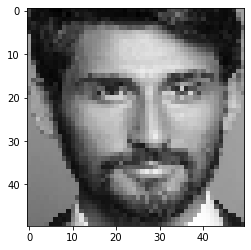

In [68]:
# let's see an example of the data we've gathered
data[0][0]
plt.imshow(data[0][0], cmap='gray')
len(data)

In [88]:
len(data)

5749

# Separating Labels & Features

In [119]:
x = list()
y = list()
for features, labels in data:
    x.append(features)
    y.append(labels)

# print(y)
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y.shape

(5749,)

In [120]:
x = np.array(x).reshape(-1,50,50,1)
x = tf.keras.utils.normalize(x, axis=1)
from keras.utils import to_categorical
y = to_categorical(y)
# y

# Model Fitting

In [121]:
# from keras.layers import LSTM
kernel_size = (3, 3)
image_shape = (50, 50, 3)

model = Sequential([
    Conv2D(
        100, 
        kernel_size, 
        input_shape=x.shape[1:], 
        activation='relu', 
        strides=2
    ),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])


model_path = '../models/mnm/kaggle_relu_softmax_1e31e5_take2'
checkpoint_path = '../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint'

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = False,
    mode = 'auto'
)

logger = CSVLogger(os.path.join(model_path, 'logs/training.csv'))

In [122]:
# NOTE: here's something cool - we can use checkpoints
#       to save/load the weights from previous model training

# if os.path.exists(checkpoint_path):
#     model.load_weights(os.path.join(checkpoint_path, 'variables/variables'))
    
# alternatively, we can load the whole model from the checkpoint state
# if os.path.exists(checkpoint_path):
#     model = load_model(checkpoint_path)

In [123]:
#  WARNING: THIS TAKES TIME -- USE THE COMPILED MODEL IF POSSIBLE
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x, y, epochs=30, batch_size=5, callbacks=[checkpoint, logger])
# model.save("../models/kaggle_relu_softmax_1e31e5_take2")

# kaggle_relu_softmax_1e31e5

Train on 5749 samples
Epoch 1/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.5691 - acc: 0.7278
Epoch 00001: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 39s 7ms/sample - loss: 0.5689 - acc: 0.7280
Epoch 2/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.4730 - acc: 0.7713
Epoch 00002: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 38s 7ms/sample - loss: 0.4729 - acc: 0.7713
Epoch 3/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.4225 - acc: 0.8144
Epoch 00003: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu

5745/5749 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9737
Epoch 00023: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 36s 6ms/sample - loss: 0.0702 - acc: 0.9737
Epoch 24/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9702
Epoch 00024: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint/assets
5749/5749 [==============================] - 36s 6ms/sample - loss: 0.0776 - acc: 0.9701
Epoch 25/30
5745/5749 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9765
Epoch 00025: saving model to ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoint
INFO:tensorflow:Assets written to: ../models/mnm/kaggle_relu_softmax_1e31e5_take2.checkpoin

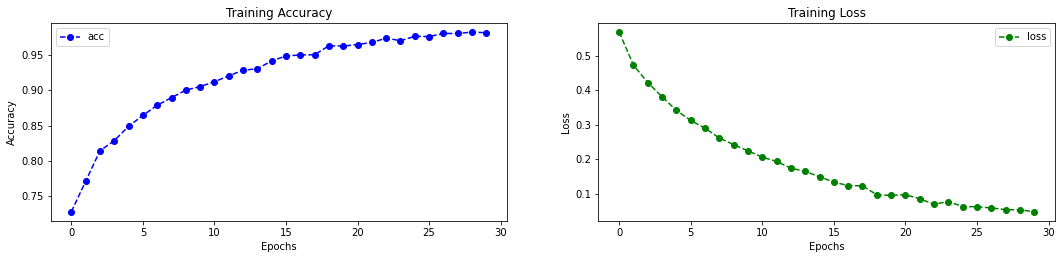

In [125]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(18,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
#     plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("Training Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'go--', label = "loss")
#     plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("Training Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)
# fig = plt.figure(figsize=(18,8))
# plt.plot(history.history['acc'],'ro--', label = "acc")
# plt.plot(history.history['loss'],'bo--', label = "loss")
# plt.title("Training Accuracy vs. Training Loss")
# plt.ylabel("Accuracy")
# plt.xlabel("Loss")


In [126]:
def get_face_bounds(img):

    detector = MTCNN()
    url = os.path.join(KAGGLE_GIT_DIR, "{}?raw=true".format(img))
    resp = urllib.request.urlopen(url)
    image = plt.imread(resp, format='jpg')
#     image = plt.imread(os.path.join(images_dir, img))
    faces = detector.detect_faces(image)
    img = np.array(img)
#     print(faces)
    bounds = []
    img = np.array(image)
    bounding_box = faces[0]['box']
    keypoints = faces[0]['keypoints']
    for (x, y, w, h) in [face['box'] for  face in faces]:
        cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              19)
        cv2.circle(img,(keypoints['left_eye']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['right_eye']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['nose']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['mouth_left']), 2, (0,155,255), 19)
        cv2.circle(img,(keypoints['mouth_right']), 2, (0,155,255), 19)
        plt.imshow(img)
        bounds.append(img)

    return bounds

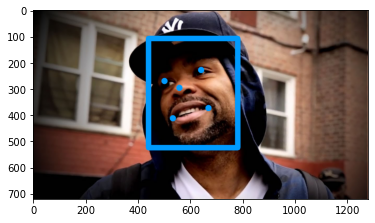

In [132]:
image = test_images[0]
bounding_boxes =  get_face_bounds(image)

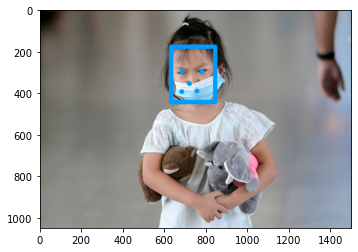

In [133]:
image = test_images[2]
bounding_boxes = get_face_bounds(image)

In [157]:
# use haar cascade to detect faces (frontal)
# HC_FRONTAL_FACE = os.path.join(HC_DATA_DIR, 
#                                'haarcascade_frontalface_default.xml')
# classifier = cv2.CascadeClassifier(HC_FRONTAL_FACE)


# use MTCNN to detect faces
classifier = MTCNN()


labels_dict={ 0:'No Mask', 1:'Mask' }
color_dict={ 0: (0,0,255), 1: (0,255,0) }

size = 4

# open webcam feed
# cap = cv2.VideoCapture(0)

# alternatively, open feed from a file
cap = cv2.VideoCapture('../memask4.mov')

# EVEN from a mobile device (UNTESTED)
# cap = cv.VideoCapture(1)

frame_count = 1
while cap.isOpened():
    ret, frame = cap.read()
    if frame is not None:
        frame = cv2.flip(frame, 1, 1) # flip so view looks more natural live (?)
        
        # detection is a little faster on smaller images -- so let's make it small
        small = cv2.resize(frame, (frame.shape[1] // size, frame.shape[0] // size))

        # detect faces with haar cascades
        # faces = classifier.detectMultiScale(small)
        
        # detect faces with MTCNN
        faces = classifier.detect_faces(small)

        for f in faces:
            # reverse the scale-down of the frame for bounding box (haar)
            # (x, y, w, h) = [v * size for vstack in f] 
            # keypoints = None
            
            # reverse the scale-down of the frame for bounding box (MTCNN)
            (x, y, w, h) = [v * size for v in f['box']]
            # print(f['keypoints'])
            keypoints = f['keypoints']
                
        
            face = frame[y:y+h, x:x+w]
            resized = cv2.resize(face, (50,50))
            normalized = resized/255.0
            reshaped = np.reshape(normalized,(-1,50,50,1))
            reshaped = np.vstack([reshaped])
            result = model.predict(reshaped)
#             print(result)

            label = np.argmax(result, axis=1)[0]
            cv2.rectangle(frame, (x,y), (x+w,y+h), color_dict[label], 2)
            cv2.rectangle(frame, (x,y-40), (x+w,y), color_dict[label], -1)
            cv2.putText(
                frame, 
                labels_dict[label], 
                (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255,255,255),
                2
            )
            
            # extra fun when using MTCNN :)
            if keypoints is not None:
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['left_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['right_eye']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['nose']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_left']])), 
                    2, (255,0,255), 2
                )
                cv2.circle(
                    frame, 
                    (tuple([k * size for k in keypoints['mouth_right']])), 
                    2, (255,0,255), 2)
            # end of extra fun with MTCNN

        cv2.imshow('LIVE DETECTION ACTIVE', frame)
        key = cv2.waitKey(10)

        if key == 27: # if Esc key pressed -- end feed
            break

    else:
        break

    frame_count += 1
# stop video
cap.release()

# close windows
cv2.destroyAllWindows()